In [75]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [76]:
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [77]:
def add_zeros(input, s):
    z = s - 1
    input_sz = input.shape[0]
    pos = np.arange(1, input_sz)
    pos = np.repeat(pos, z)

    zero_inserted_input = np.insert(input, pos, 0, axis=1)
    zero_inserted_input = np.insert(zero_inserted_input, pos, 0, axis=0)

    new_input = zero_inserted_input
    return new_input

def convolve(input, kernel, output_sz):
    convolved = np.zeros((output_sz, output_sz))
    kernel_sz = kernel.shape[0]
    for i in range(output_sz):
        for j in range(output_sz):
            sub_matrix = input[i:i+kernel_sz, j:j+kernel_sz]
            convolved[i, j] = np.sum(np.multiply(sub_matrix, kernel))
    return convolved
    
def transposed_conv(input, kernel, s, p):
    input_sz = input.shape[0]
    kernel_sz = kernel.shape[0]
    output_sz = (input_sz - 1) * s + kernel_sz - 2 * p
    new_input = add_zeros(input, s)
    return convolve(new_input, kernel, output_sz)


In [78]:
test_input = np.array([[2, 4, 4],
                       [0, 1, 3],
                       [1, 2, 4]])

test_kernel = np.array([[3, 1],
                        [1, 5]])


transpose_convolution = transposed_conv(
    test_input, test_kernel, 2, 1)

print('transpose conv:\n', transpose_convolution)
print('\n')
print('added_zeros:\n',add_zeros(test_input, 2))
print('\n')
print('kernel:\n', test_kernel)


transpose conv:
 [[ 6.  4. 12.  4.]
 [ 0.  5.  1. 15.]
 [ 0.  1.  3.  3.]
 [ 1. 10.  2. 20.]]


added_zeros:
 [[2 0 4 0 4]
 [0 0 0 0 0]
 [0 0 1 0 3]
 [0 0 0 0 0]
 [1 0 2 0 4]]


kernel:
 [[3 1]
 [1 5]]


In [79]:
class CFG:
    root_path = './data'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 64
    label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
    seed = 99
    
def seed_everything():
    np.random.seed(CFG.seed)
    torch.manual_seed(CFG.seed)
    torch.cuda.manual_seed(CFG.seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

In [80]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root=CFG.root_path, train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=CFG.batch_size,
                                          shuffle=False)

testset = torchvision.datasets.CIFAR10(root=CFG.root_path, train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=CFG.batch_size,
                                         shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [81]:
def show_image(image, label):
    label_list = CFG.label_list
    img = np.transpose(image, (1,2,0))
    plt.title(label_list[label])
    plt.axis('off')
    plt.imshow(img)

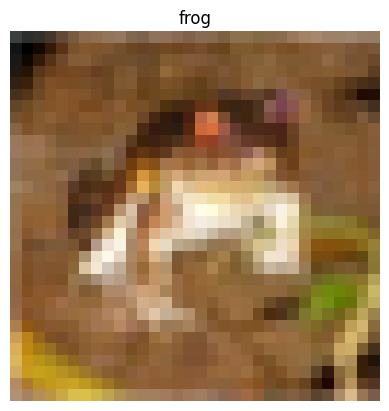

In [82]:
show_image(train_loader.dataset[0][0], train_loader.dataset[0][1])

In [83]:
def add_noise(image, mean=0, variance=0.1):
    # torch.rand_like : Returns a tensor with the same size as :attr:`input` that is filled
    # with random numbers from a normal distribution with mean 0 and variance 1
    noise = torch.randn_like(image) * variance + mean
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

data_iter = iter(train_loader)
image, label = next(data_iter)

# Add noise to the example image
noisy_example = add_noise(image)

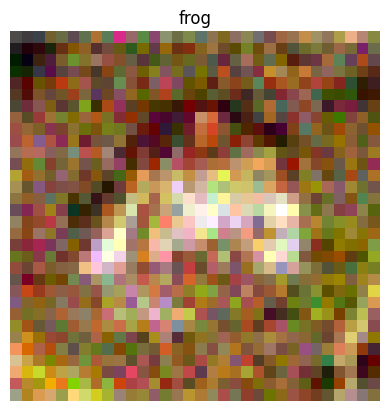

In [84]:
show_image(noisy_example[0], label[0])

In [85]:
class NoisyDataset(Dataset):
    def __init__(self, clean_images, mean=0, variance=0.1):
        self.clean_images = clean_images
        self.mean = mean
        self.variance = 0.1
        
    def __len__(self):
        return len(self.clean_images)
    
    def __getitem__(self, idx):
        clean_image = self.clean_images[idx][0]
        label = self.clean_images[idx][1]
        noisy_image = self.add_noise(clean_image, self.variance, self.mean)
        return noisy_image, label
    
    def add_noise(self, image, var, mean):
        noise = torch.randn_like(image) * var + mean
        noisy_image = image + noise
        noisy_image = torch.clamp(noisy_image, 0, 1)
        return noisy_image

In [86]:
noisy_trainset = NoisyDataset(trainset)
noisy_testset = NoisyDataset(testset)

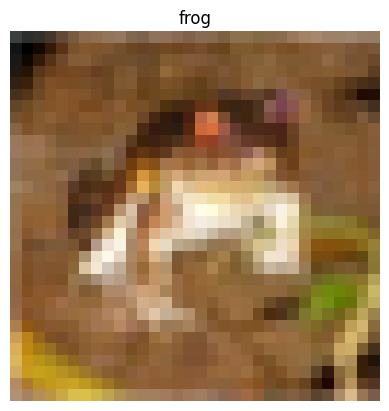

In [87]:
show_image(trainset[0][0], trainset[0][1])

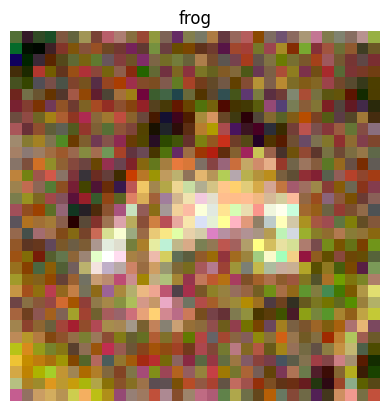

In [88]:
show_image(noisy_trainset[0][0], noisy_trainset[0][1])

In [89]:
noisy_train_loader = DataLoader(noisy_trainset, batch_size = CFG.batch_size, shuffle=False)
noisy_test_loader = DataLoader(noisy_testset, batch_size = CFG.batch_size, shuffle=False)

In [90]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  

        self.conv2 = nn.Conv2d(64, 16, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # latent
        return x
        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.t_conv1 = nn.ConvTranspose2d(16, 64, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(64, 3, 2, stride=2)
        
    def forward(self, x):
        ## decode ##
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
        
        return x

class ConvDenoiser(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.encoder.to(CFG.device)

        self.decoder = decoder
        self.decoder.to(CFG.device)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [91]:
encoder = Encoder()
decoder = Decoder()
denoiseAE = ConvDenoiser(encoder, decoder).to(CFG.device)
denoiseAE

ConvDenoiser(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (t_conv1): ConvTranspose2d(16, 64, kernel_size=(2, 2), stride=(2, 2))
    (t_conv2): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(2, 2))
  )
)

In [92]:
criterion = nn.MSELoss()
optimizer = optim.Adam(denoiseAE.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-3, last_epoch=-1)

In [93]:
def train_AE(epoch):
    print('\nEpoch: %d' % (epoch +1))
    denoiseAE.train()
    train_loss = 0
    for i, (clean_data, noisy_data) in enumerate(zip((train_loader), noisy_train_loader)):
        clean_img, _ = clean_data
        noisy_img, _ = noisy_data
        clean_img, noisy_img = clean_img.to(CFG.device), noisy_img.to(CFG.device)
        
        optimizer.zero_grad()
        outputs = denoiseAE(noisy_img)
        loss = criterion(outputs, clean_img)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss/len(train_loader)
    scheduler.step()
    return train_loss

In [94]:
for epoch in range(0, 10):
    loss = train_AE(epoch)
    print('Total loss:', loss)


Epoch: 1
Total loss: 0.0076067590659670056

Epoch: 2
Total loss: 0.004975322658991646

Epoch: 3
Total loss: 0.004598161533160511

Epoch: 4
Total loss: 0.00435329300632505

Epoch: 5
Total loss: 0.004195318061886998

Epoch: 6
Total loss: 0.00408196426205137

Epoch: 7
Total loss: 0.003995955015992379

Epoch: 8
Total loss: 0.003928017107915143

Epoch: 9
Total loss: 0.003888708316301808

Epoch: 10
Total loss: 0.003859994073739023


In [95]:
out = denoiseAE(next(iter(noisy_test_loader))[0].to(CFG.device))

In [96]:
def plot_result():
    images, labels = next(iter(test_loader))
    images = images.numpy()

    noisy_imgs, labels = next(iter(noisy_test_loader))
    noisy_imgs = noisy_imgs.numpy()

    out = denoiseAE(next(iter(noisy_test_loader))[0].to(CFG.device))
    out = out.cpu().detach().numpy()

    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(
        nrows=3, ncols=10, sharex=True, sharey=True, figsize=(25, 7))

    # input images on top row, reconstructions on bottom
    for noisy_imgs, row in zip([images, noisy_imgs, out], axes):
        for img, ax in zip(noisy_imgs, row):
            img = np.transpose(img, (1, 2, 0))
            ax.imshow(np.squeeze(img))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.figtext(0.5, 0.95, "ORIGINAL IMAGES", ha="center",
                va="top", fontsize=14, color="r")
    plt.figtext(0.5, 0.65, "NOISY IMAGES", ha="center",
                va="top", fontsize=14, color="r")
    plt.figtext(0.5, 0.35, " DENOISED RECONSTRUCTED IMAGES",
                ha="center", va="top", fontsize=14, color="r")
    plt.subplots_adjust(hspace=0.5)


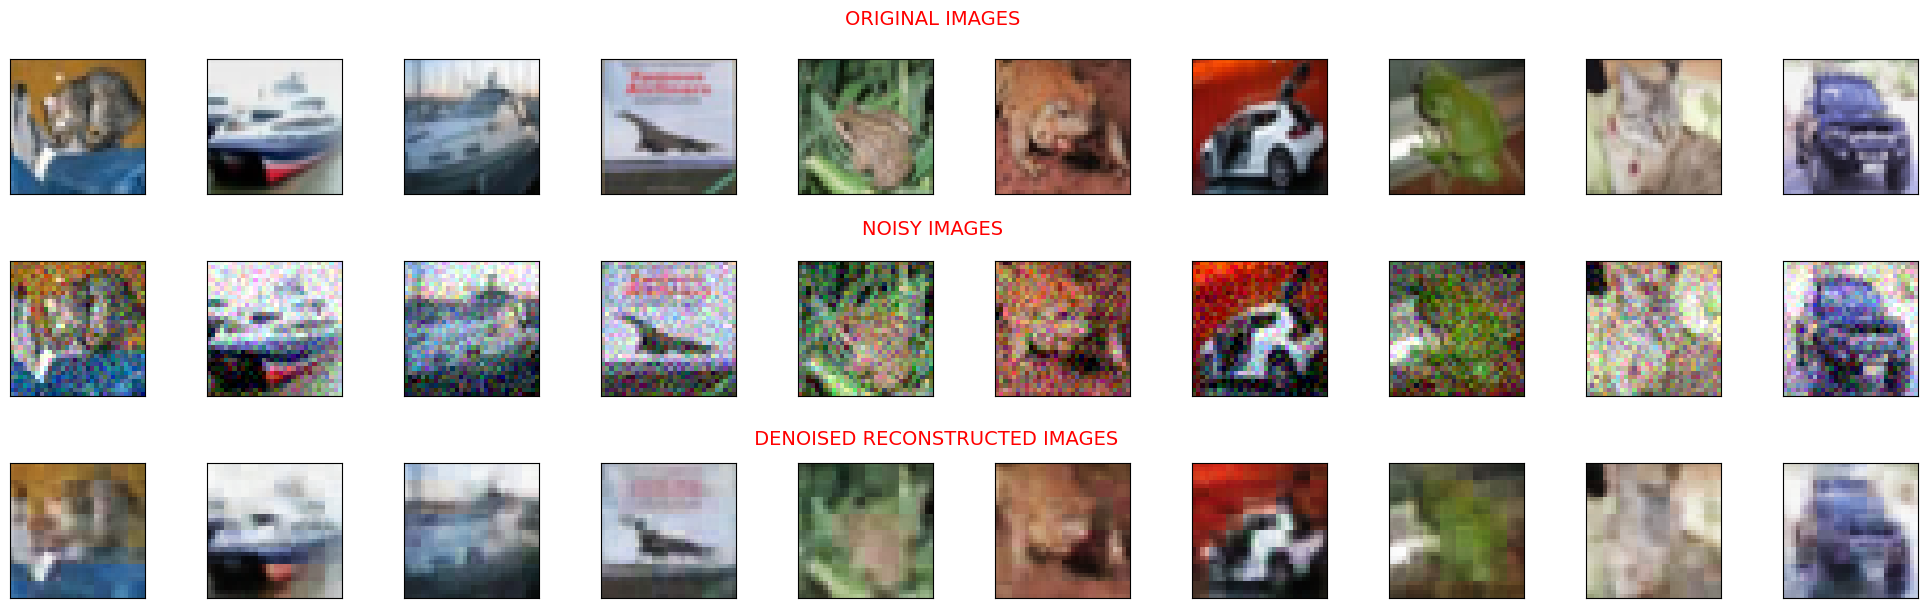

In [97]:
plot_result()

# BAI 3

In [101]:
flattened_image = train_loader.dataset[0][0].reshape(-1, 3)
pca = PCA(n_components=2)
reduced_image = pca.fit_transform(flattened_image)

Text(0.5, 1.0, 'PCA Visualization')

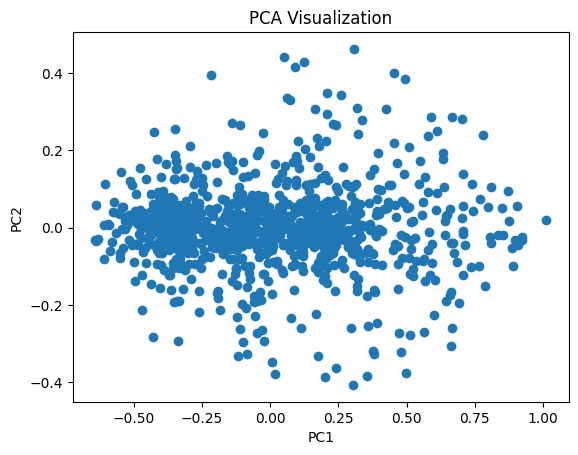

In [102]:
df_pca = pd.DataFrame(reduced_image, columns=['PC1', 'PC2'])
plt.plot(df_pca['PC1'], df_pca['PC2'], 'o')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Visualization')

In [107]:
encoder(train_loader.dataset[0][0]).shape

torch.Size([8, 8, 8])